Для решения задачи регрессии было решено сменить датасет

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Взят датасет для предсказания стоимости поездки в такси  
https://www.kaggle.com/datasets/denkuznetz/taxi-price-prediction

In [2]:
df = pd.read_csv('C:/Users/leous/.vscode/Data_Mining/content/taxi_trip_pricing.csv')
df.head()

,Trip_Distance_km,Time_of_Day,Day_of_Week,Passenger_Count,Traffic_Conditions,Weather,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
0,19.35,Morning,Weekday,3.0,Low,Clear,3.56,0.80,0.32,53.82,36.2624
1,47.59,Afternoon,Weekday,1.0,High,Clear,NaN,0.62,0.43,40.57,NaN
2,36.87,Evening,Weekend,1.0,High,Clear,2.70,1.21,0.15,37.27,52.9032
3,30.33,Evening,Weekday,4.0,Low,NaN,3.48,0.51,0.15,116.81,36.4698
4,NaN,Evening,Weekday,3.0,High,Clear,2.93,0.63,0.32,22.64,15.6180


In [3]:
df.describe()

,Trip_Distance_km,Passenger_Count,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
count,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,951.000000
mean,27.070547,2.476842,3.502989,1.233316,0.292916,62.118116,56.874773
std,19.905300,1.102249,0.870162,0.429816,0.115592,32.154406,40.469791
min,1.230000,1.000000,2.010000,0.500000,0.100000,5.010000,6.126900
25%,12.632500,1.250000,2.730000,0.860000,0.190000,35.882500,33.742650
50%,25.830000,2.000000,3.520000,1.220000,0.290000,61.860000,50.074500
75%,38.405000,3.000000,4.260000,1.610000,0.390000,89.055000,69.099350
max,146.067047,4.000000,5.000000,2.000000,0.500000,119.840000,332.043689


In [4]:
mapping = {}
for col in df.columns:
    if df[col].unique().size == 2:
        t, f = df[col].unique()[0], df[col].unique()[1]
        mapping[col] = {True : t, False : f}
        df[col] = df[col].map({t: True, f: False})
    # else:
        # print(col, df[col].unique())
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Trip_Distance_km       950 non-null    float64
 1   Time_of_Day            950 non-null    object 
 2   Day_of_Week            950 non-null    object 
 3   Passenger_Count        950 non-null    float64
 4   Traffic_Conditions     950 non-null    object 
 5   Weather                950 non-null    object 
 6   Base_Fare              950 non-null    float64
 7   Per_Km_Rate            950 non-null    float64
 8   Per_Minute_Rate        950 non-null    float64
 9   Trip_Duration_Minutes  950 non-null    float64
 10  Trip_Price             951 non-null    float64
dtypes: float64(7), object(4)
memory usage: 86.1+ KB


Часть значений - nan. Заменим на медиану или моду

In [5]:
def fillna_with_median_mode(df):
    for col in df.columns:
        if df[col].dtype == 'object' or df[col].dtype.name == 'category':
            # Если столбец категориальный, заполняем модой
            mode_value = df[col].mode().iloc[0]
            df[col].fillna(mode_value, inplace=True)
        else:
            # Если столбец числовой, заполняем медианой
            median_value = df[col].median()
            df[col].fillna(median_value, inplace=True)
            
    return df

filled_df = fillna_with_median_mode(df)
# print(filled_df)

In [6]:
mapping = {}
for col in filled_df.columns:
    if filled_df[col].unique().size == 2:
        t, f = filled_df[col].unique()[0], filled_df[col].unique()[1]
        mapping[col] = {True : t, False : f}
        filled_df[col] = filled_df[col].map({t: True, f: False})
    # else:
        # print(col, filled_df[col].unique())
filled_df.head()

,Trip_Distance_km,Time_of_Day,Day_of_Week,Passenger_Count,Traffic_Conditions,Weather,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
0,19.35,Morning,True,3.0,Low,Clear,3.56,0.80,0.32,53.82,36.2624
1,47.59,Afternoon,True,1.0,High,Clear,3.52,0.62,0.43,40.57,50.0745
2,36.87,Evening,False,1.0,High,Clear,2.70,1.21,0.15,37.27,52.9032
3,30.33,Evening,True,4.0,Low,Clear,3.48,0.51,0.15,116.81,36.4698
4,25.83,Evening,True,3.0,High,Clear,2.93,0.63,0.32,22.64,15.6180


In [7]:
mas_float64 = filled_df.select_dtypes(include=['float64']).columns
mas_bool = filled_df.select_dtypes(include=['bool']).columns
mas_others = filled_df.select_dtypes(exclude=['float64','bool']).columns

In [8]:
mas_float64

Index(['Trip_Distance_km', 'Passenger_Count', 'Base_Fare', 'Per_Km_Rate',
       'Per_Minute_Rate', 'Trip_Duration_Minutes', 'Trip_Price'],
      dtype='object')

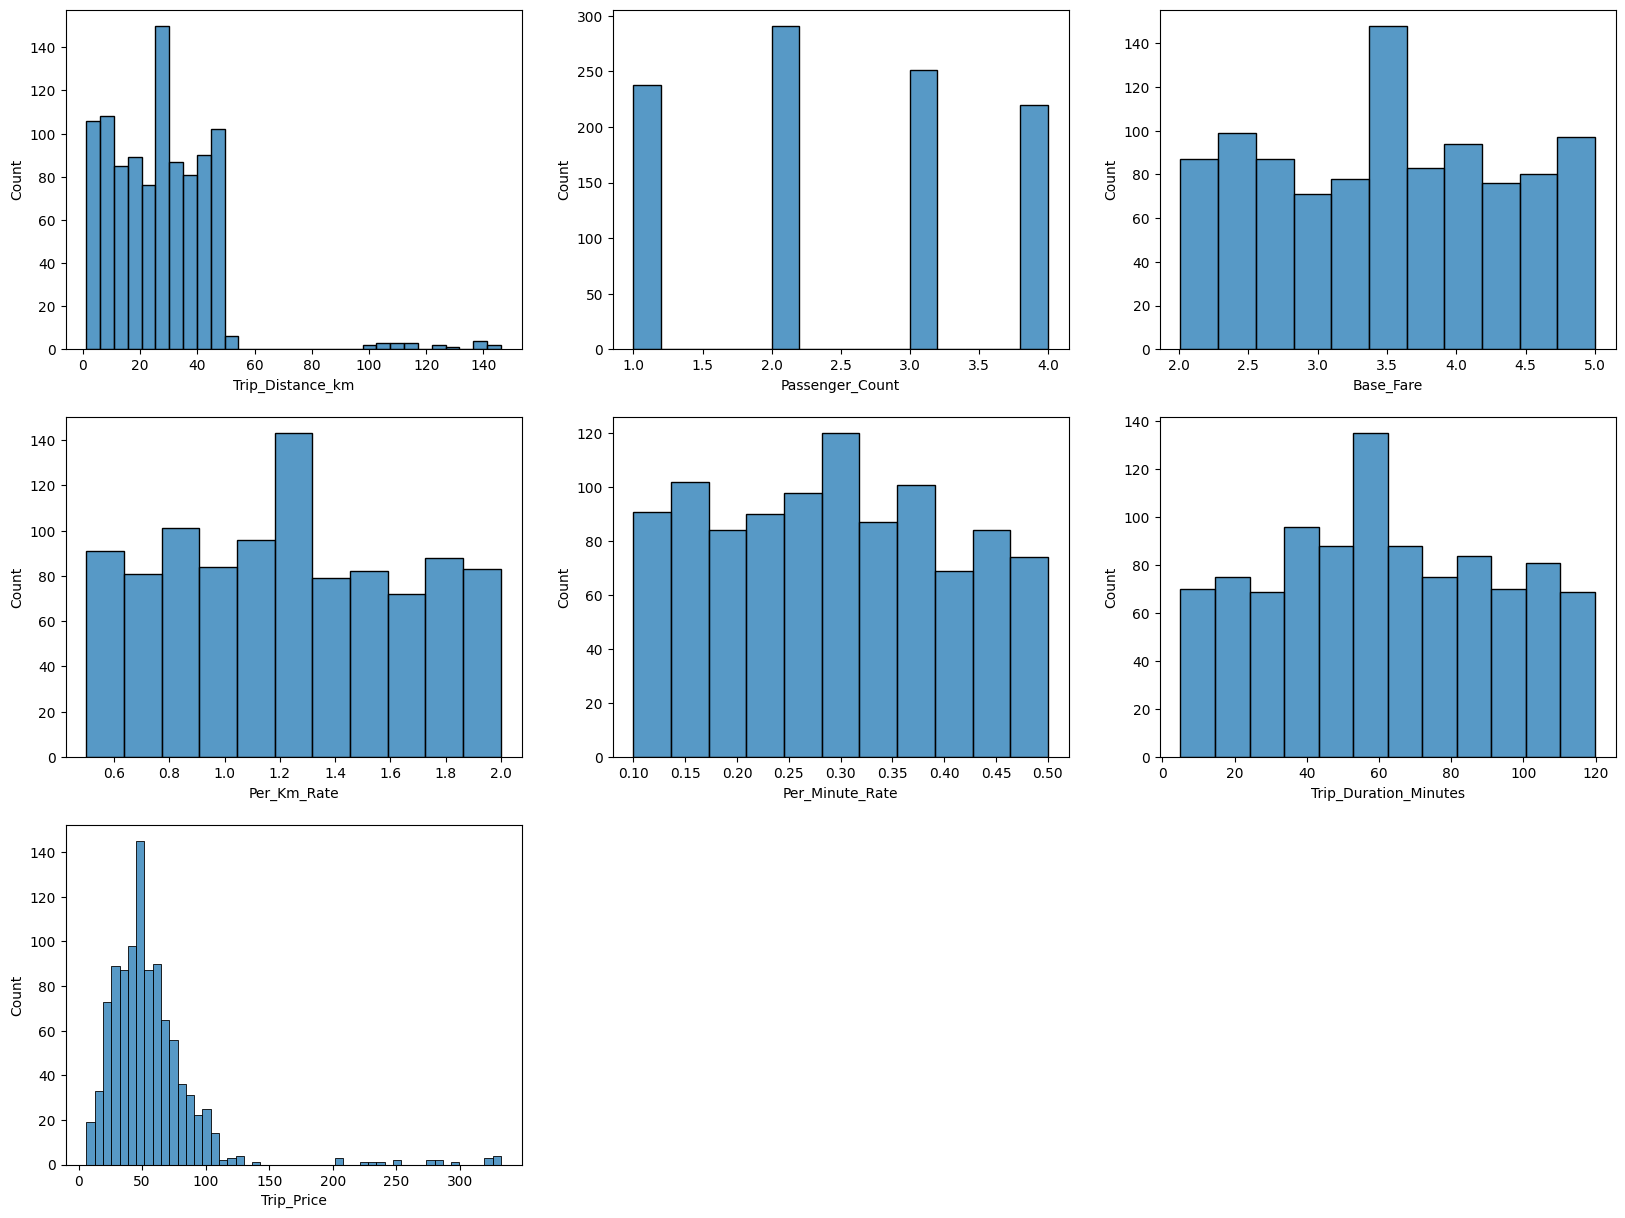

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))

for i in range(3):
    for j in range(3):
        axes[i][j].set_visible(False)


for col in enumerate(mas_float64):
    axes[col[0] // 3][col[0] % 3].set_visible(True)
    sns.histplot(data=filled_df, x=col[1], ax= axes[col[0] // 3, col[0] % 3]);
plt.show()

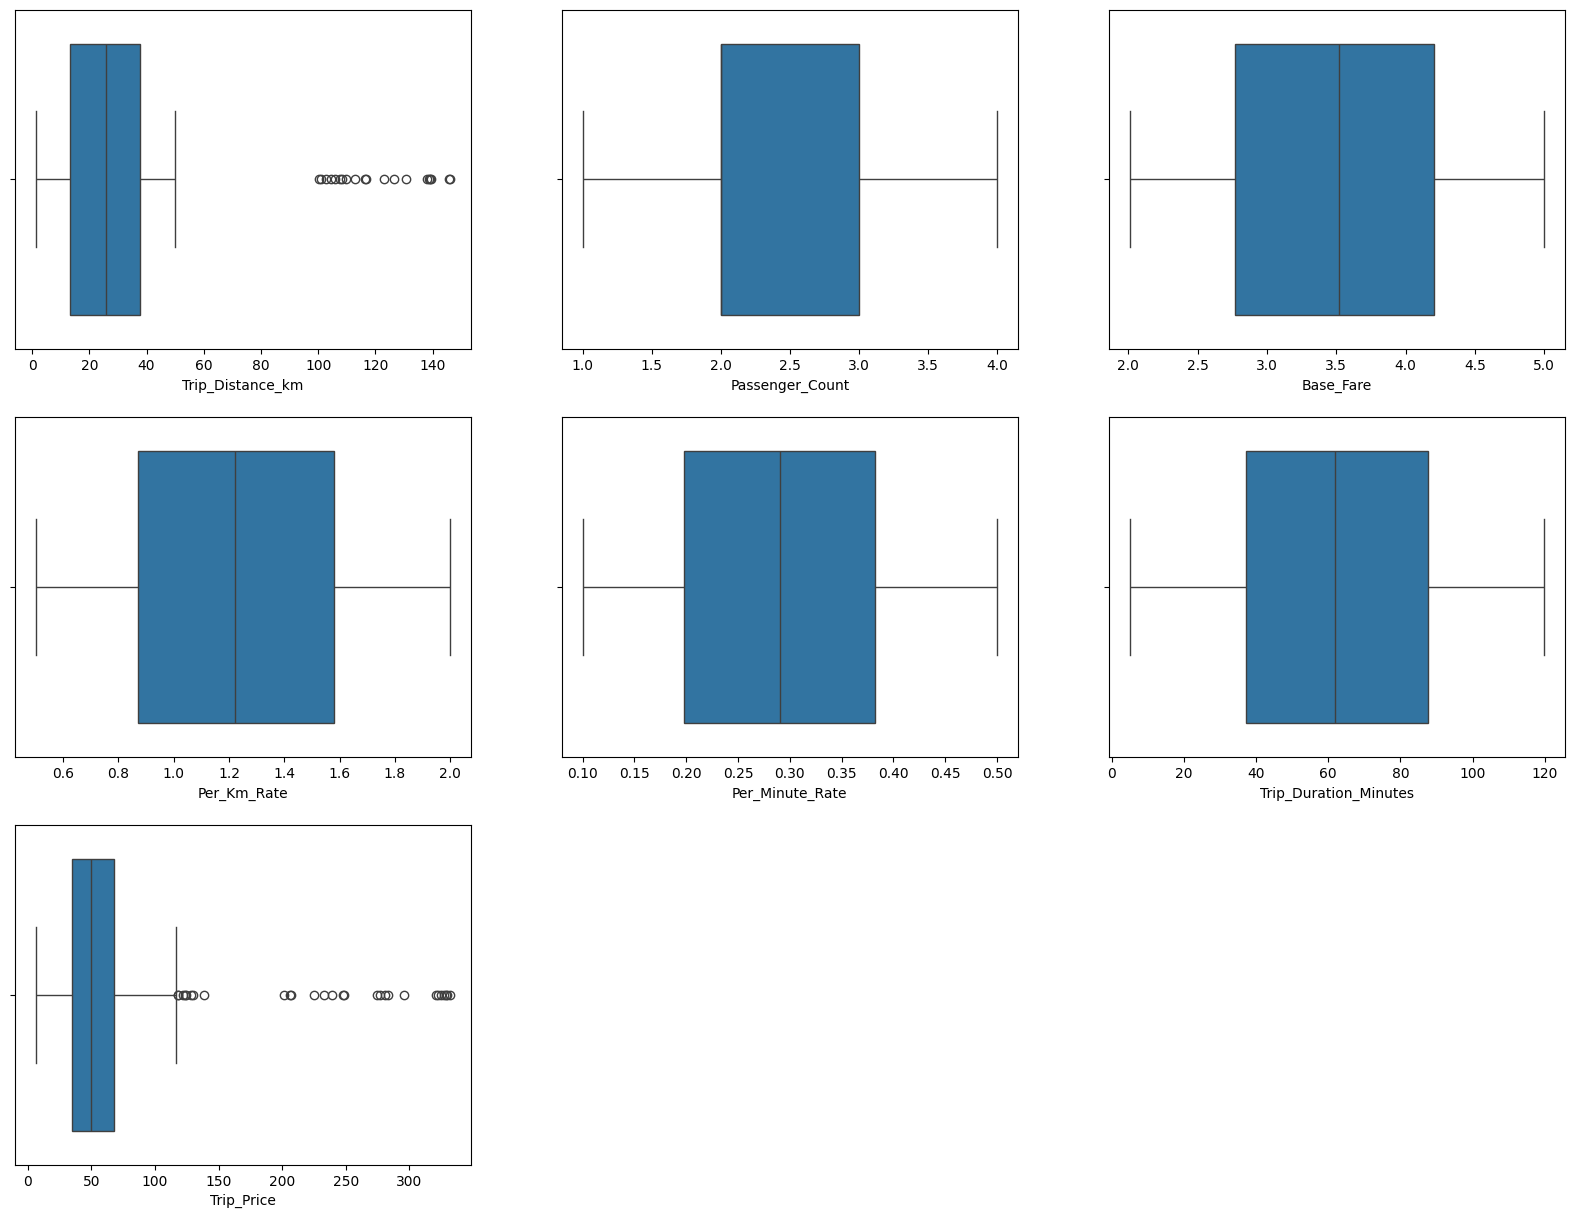

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))

for i in range(3):
    for j in range(3):
        axes[i][j].set_visible(False)


for col in enumerate(mas_float64):
    axes[col[0] // 3][col[0] % 3].set_visible(True)
    sns.boxplot(data=filled_df, x=col[1], ax= axes[col[0] // 3, col[0] % 3]);
plt.show()

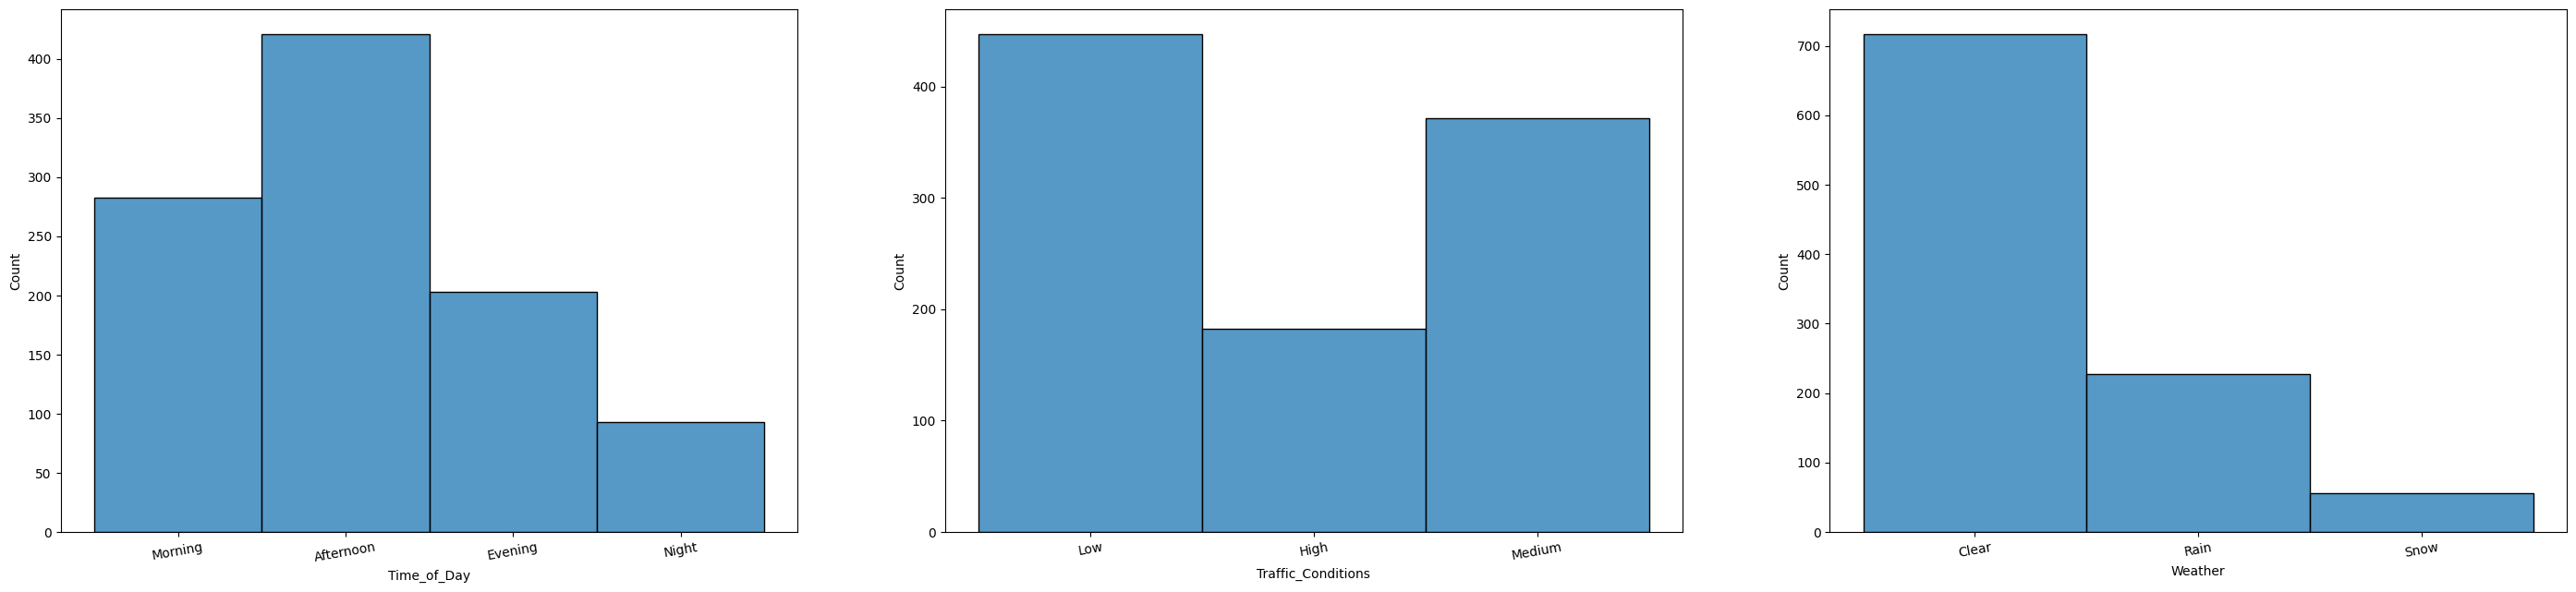

In [11]:
from matplotlib.ticker import FixedLocator, FixedFormatter
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(35, 25))

for i in range(3):
    for j in range(3):
        axes[i][j].set_visible(False)

for col in enumerate(mas_others):
    axes[col[0] // 3][col[0] % 3].set_visible(True)
    ax= axes[col[0] // 3, col[0] % 3]
    sns.histplot(data=filled_df, x=col[1], ax = ax)
    tick_labels = ax.get_xticklabels()

    locator = FixedLocator(range(len(tick_labels)))
    formatter = FixedFormatter([label.get_text() for label in tick_labels])

    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=10)

axes[2][1].set_visible(False)
axes[2][2].set_visible(False)
plt.show()

In [12]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline

Избавимся от выбросов

In [13]:
def is_outlier(x, mean, std):
    lower_bound = mean - 3 * std
    upper_bound = mean + 3 * std
    return ~((x > lower_bound) & (x < upper_bound))

for col in ['Trip_Distance_km', 'Trip_Price']:
    mean = filled_df[col].mean()
    std = filled_df[col].std()
    outliers = filled_df[col].apply(lambda x: is_outlier(x, mean, std))
    filled_df = filled_df[~outliers]

In [14]:
filled_df.head()

,Trip_Distance_km,Time_of_Day,Day_of_Week,Passenger_Count,Traffic_Conditions,Weather,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
0,19.35,Morning,True,3.0,Low,Clear,3.56,0.80,0.32,53.82,36.2624
1,47.59,Afternoon,True,1.0,High,Clear,3.52,0.62,0.43,40.57,50.0745
2,36.87,Evening,False,1.0,High,Clear,2.70,1.21,0.15,37.27,52.9032
3,30.33,Evening,True,4.0,Low,Clear,3.48,0.51,0.15,116.81,36.4698
4,25.83,Evening,True,3.0,High,Clear,2.93,0.63,0.32,22.64,15.6180


In [15]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics._regression import explained_variance_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

MSE: 97.12 (25.59)
MAE: 7.16 (0.88)
R2: 0.81 (0.04)
Explained Variance: 0.82 (0.04)


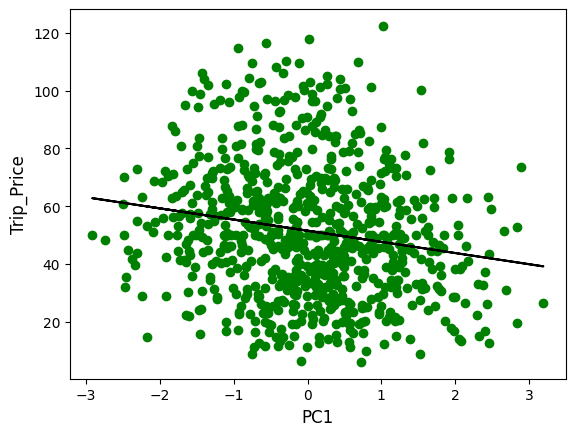

In [16]:
def metrics_and_visualisation(model_class, df, **kwargs):
    model = model_class(**kwargs)
    preprocessor = ColumnTransformer(
        transformers=[
            ('onehot', OneHotEncoder(handle_unknown='ignore'), mas_others)
        ],
        remainder='passthrough'
    )

    X = df.drop(['Trip_Price'], axis=1)
    y = df['Trip_Price']

    # делим датасет на трейн и тест
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=15)

    # Определение пайплайна
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

    # Кросс-валидация с использованием KFold
    kfold = KFold(n_splits=10, random_state=1, shuffle=True)

    metrics = {
        'MSE': make_scorer(mean_squared_error, greater_is_better=False),
        'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
        'R2': make_scorer(r2_score, greater_is_better=True),
        'Explained Variance': make_scorer(explained_variance_score, greater_is_better=True)
    }

    # pipeline.fit(X_train, y_train)

    # # Прогнозирование результатов на тестовых данных
    # prediction = pipeline.predict(X_test)
    # r2 = r2_score(y_test, prediction)
    # print(f"R2: {r2:.2f}")

    # Выполнение кросс-валидации для каждой метрики
    for metric_name, scorer in metrics.items():
        cv_results = cross_val_score(pipeline, X, y, cv=kfold, scoring=scorer)
        if scorer._sign >0:
            print(f'{metric_name}: {cv_results.mean():.2f} ({cv_results.std():.2f})')
        else:
            print(f'{metric_name}: {-cv_results.mean():.2f} ({cv_results.std():.2f})')

    X2 = X_train.copy()
    cat_cols = (X2.dtypes == 'object')

    # Создаем преобразователь для категориальных данных
    ord_enc = OrdinalEncoder()

    X2[X2.columns[cat_cols]] = ord_enc.fit_transform(X2[X2.columns[cat_cols]])
    pipeline = Pipeline(steps=[('scale', StandardScaler()), ('pca', PCA(n_components=1))])
    
    X2[['PC1']] = pipeline.fit_transform(X2)
    # попробуем отрисовать, как выглядит наша линейная регрессия
    # X2 = df['PC1'].values[:,np.newaxis]
    X2 = X2[['PC1']].values
    # target data is array of shape (n,)
    y2 = y_train.values

    model2 = model_class(**kwargs)
    model2.fit(X2, y2)

    plt.scatter(X2, y2,color='g')
    plt.plot(X2, model2.predict(X2),color='k')
    plt.ylabel('Trip_Price', size=12)
    plt.xlabel('PC1', size=12)
    plt.show()

metrics_and_visualisation(LinearRegression, filled_df)

MSE: 146.26 (25.40)
MAE: 9.10 (0.70)
R2: 0.71 (0.04)
Explained Variance: 0.71 (0.04)


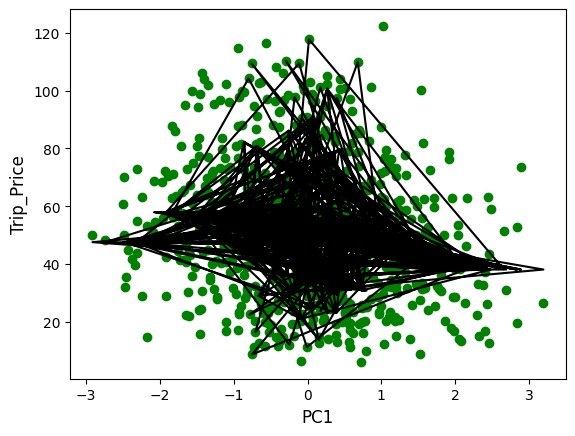

In [17]:
from sklearn.tree import DecisionTreeRegressor
metrics_and_visualisation(DecisionTreeRegressor, filled_df, max_leaf_nodes=80)

MSE: 78.10 (23.10)
MAE: 5.89 (0.52)
R2: 0.84 (0.04)
Explained Variance: 0.85 (0.04)


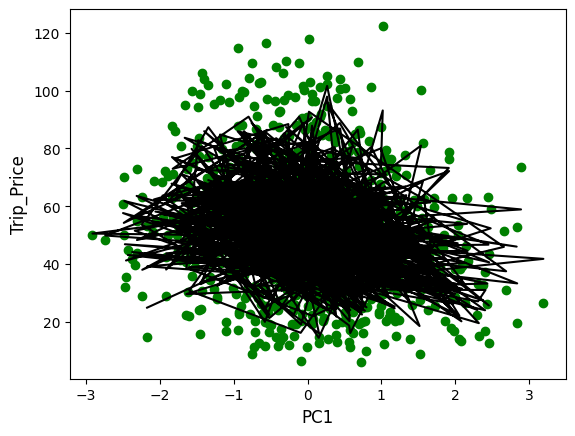

In [18]:
from sklearn.ensemble import RandomForestRegressor
metrics_and_visualisation(RandomForestRegressor, filled_df)

MSE: 104.69 (22.29)
MAE: 7.63 (0.88)
R2: 0.80 (0.03)
Explained Variance: 0.80 (0.03)


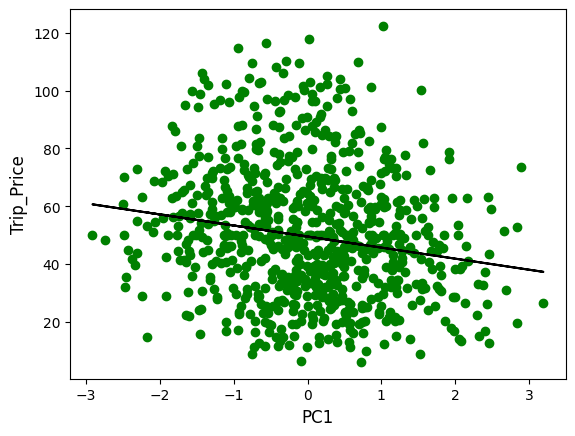

In [19]:
from sklearn.svm import SVR
metrics_and_visualisation(SVR, filled_df, kernel='linear')

MSE: 308.88 (45.92)
MAE: 14.06 (1.07)
R2: 0.41 (0.04)
Explained Variance: 0.41 (0.04)


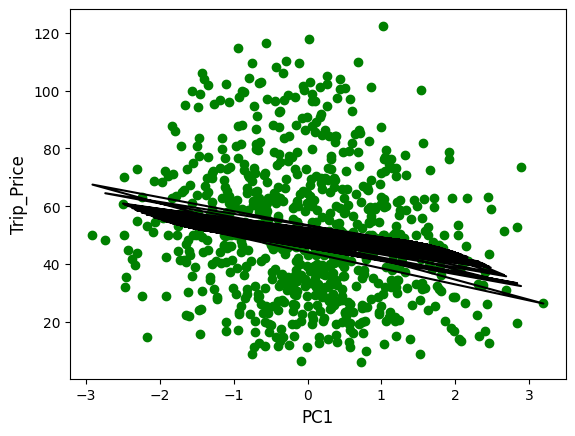

In [20]:
metrics_and_visualisation(SVR, filled_df, kernel='poly')

MSE: 259.12 (37.54)
MAE: 12.70 (0.95)
R2: 0.50 (0.03)
Explained Variance: 0.51 (0.03)


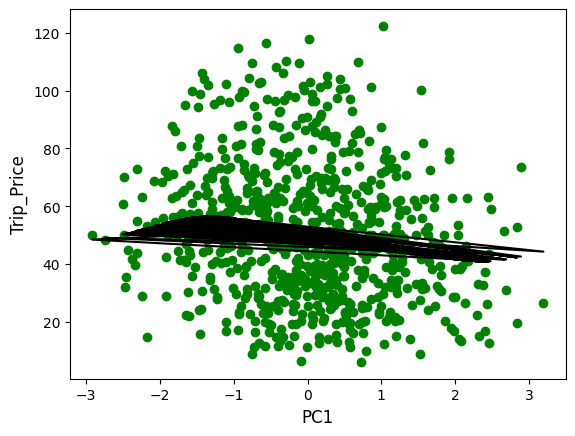

In [21]:
metrics_and_visualisation(SVR, filled_df, kernel='rbf')

MSE: 114.06 (22.39)
MAE: 8.09 (0.89)
R2: 0.78 (0.03)
Explained Variance: 0.78 (0.03)


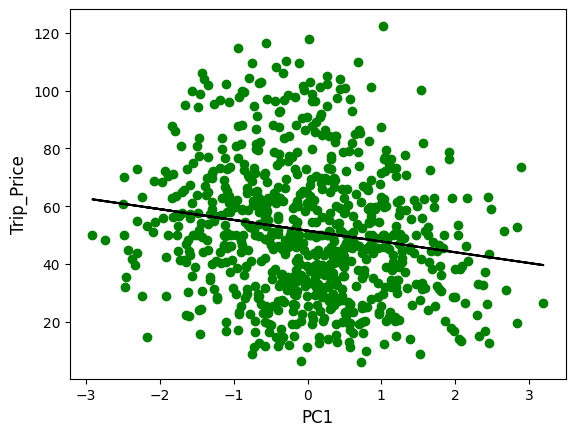

In [22]:
from sklearn.linear_model import ElasticNet
metrics_and_visualisation(ElasticNet, filled_df, alpha=0.1, l1_ratio=0.8)

MSE: 72.79 (27.87)
MAE: 5.44 (0.68)
R2: 0.86 (0.04)
Explained Variance: 0.86 (0.04)


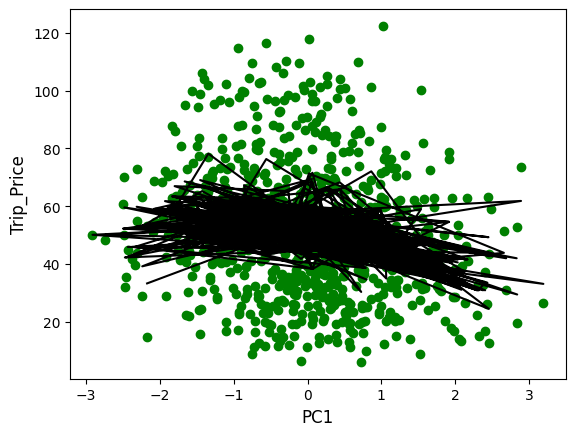

In [23]:
from sklearn.ensemble import GradientBoostingRegressor
metrics_and_visualisation(GradientBoostingRegressor, filled_df)

Лучше всего себя показали модели Random Forest и Gradient Boosting